In [1]:
import numpy as np 
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary
from torchmetrics.image import StructuralSimilarityIndexMeasure

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PRETRAINED = False
SEED = 6
LEARNING_RATE = 5e-4
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.2
NUM_EPOCHS = 500
EMBEDDING_CHANNELS = 16

OPTIMIZER = 'SGD'

DATASET_PATH = '/kaggle/input/rtx-rplots/Train'
PRETRAINED_MODEL_PATH = '/kaggle/working/autoencoder.pt'
TEST_PATH = '/kaggle/input/rtx-rplots/Test'

In [3]:
def show(data1, data2):
    '''function to compare the reconstruction obtained by the autoencoder,
    SSMI tries to maintain the structural features
    MLE tries to lower the pixelwise differences
    '''
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for i in range(1, 11):
        image_tensor1 = data1[i - 1]
        image_array1 = image_tensor1.numpy()
        image_tensor2 = data2[i - 1]
        image_array2 = image_tensor2.numpy()

        plt.subplot(2, 10, 2 * i - 1)
        plt.imshow(image_array1[0], cmap='gray')  # Assuming the first channel is the single channel
        plt.axis('off')

        plt.subplot(2, 10, 2 * i)
        plt.imshow(image_array2[0], cmap='gray')  # Assuming the first channel is the single channel
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
class AutoEncoderDataset(Dataset):
    '''AutoEncoder Dataset object, converts the images into single channel 
    '''
    def __init__(self, root_dir):
        self.root_dir = root_dir

        self.image_folder = ImageFolder(root=self.root_dir)
        self.class_to_idx = self.image_folder.class_to_idx
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.samples = self.image_folder.samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = self._load_image(img_path)
        return image, label

    def _load_image(self, img_path):
        image = Image.open(img_path)
        transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop((225,224)),
            transforms.Lambda(lambda img: img.crop((0, 0, img.width, img.height - 1))),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        image_tensor = transform(image)
        return image_tensor

In [5]:


class Autoencoder(nn.Module):
    def __init__(self, emb_size):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Flatten(),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(1024*7*7, emb_size),
            nn.ReLU(),
            nn.Dropout(0.25),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(emb_size, 1024*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (1024, 7, 7)),  # Reshape linear output to 2D shape

            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        bottleneck_output = self.bottleneck(x)
        x = self.decoder(bottleneck_output)
        return x, bottleneck_output
    
autoencoder_model = Autoencoder(EMBEDDING_CHANNELS)
summary(autoencoder_model, input_size=(BATCH_SIZE,4,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [16, 4, 224, 224]         --
├─Sequential: 1-1                        [16, 50176]               --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        2,368
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─MaxPool2d: 2-4                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-5                       [16, 128, 112, 112]       73,856
│    └─ReLU: 2-6                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-7                  [16, 128, 112, 112]       256
│    └─MaxPool2d: 2-8                    [16, 128, 56, 56]         --
│    └─Conv2d: 2-9                       [16, 256, 56, 56]         295,168
│    └─ReLU: 2-10                        [16, 256, 56, 56]         --
│    └─BatchNorm2d: 2-11                 [16, 256, 56, 56]         512


In [6]:
torch.manual_seed(SEED)

#%%%%%%%%%%%%%%%%%%%%%%%     DATASET CREATION   %%%%%%%%%%%%%%%%%%%%%%%
custom_dataset = AutoEncoderDataset(root_dir=DATASET_PATH)
val_size = int(len(custom_dataset) * TRAIN_TEST_SPLIT)
train_size = len(custom_dataset) - val_size
train_ds, val_ds = random_split(custom_dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

if PRETRAINED :
    #%%%%%%%%%%%%%%%%%%%%%%%     PRE TRAINED MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    state_dict = torch.load(PRETRAINED_MODEL_PATH)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")
        new_state_dict[new_key] = value

    autoencoder_model.load_state_dict(new_state_dict)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = nn.MSELoss()
#     criterion = StructuralSimilarityIndexMeasure(data_range=1.0)
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
else :
    # #%%%%%%%%%%%%%%%%%%%%%%%     MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = nn.MSELoss()
#     criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
    #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        autoencoder_model.train()
        train_loss = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder_model(inputs)
#             loss = 1 - criterion(outputs[0], inputs)
            loss = criterion(outputs[0], inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
#             criterion.update(outputs[0], inputs)

        autoencoder_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                outputs = autoencoder_model(inputs)
#                 loss = 1 - criterion(outputs[0], inputs)
                loss = criterion(outputs[0], inputs)
                val_loss += loss.item()
#                 criterion.update(outputs[0], inputs)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.5f} Val Loss: {val_loss:.5f}")

    torch.save(autoencoder_model.state_dict(), 'autoencoder.pt')

Epoch [5/500]: Train Loss: 5.36161 Val Loss: 0.94045
Epoch [10/500]: Train Loss: 3.70188 Val Loss: 0.94749
Epoch [15/500]: Train Loss: 2.82426 Val Loss: 0.71659
Epoch [20/500]: Train Loss: 2.34882 Val Loss: 0.61619
Epoch [25/500]: Train Loss: 1.96678 Val Loss: 0.48503
Epoch [30/500]: Train Loss: 1.73294 Val Loss: 0.43418
Epoch [35/500]: Train Loss: 1.46747 Val Loss: 0.36898
Epoch [40/500]: Train Loss: 1.27463 Val Loss: 0.31306
Epoch [45/500]: Train Loss: 1.19503 Val Loss: 0.28827
Epoch [50/500]: Train Loss: 1.12221 Val Loss: 0.26056
Epoch [55/500]: Train Loss: 1.10229 Val Loss: 0.25928
Epoch [60/500]: Train Loss: 1.04805 Val Loss: 0.24702
Epoch [65/500]: Train Loss: 1.03781 Val Loss: 0.24450
Epoch [70/500]: Train Loss: 1.01596 Val Loss: 0.24021
Epoch [75/500]: Train Loss: 0.99665 Val Loss: 0.23252
Epoch [80/500]: Train Loss: 0.98754 Val Loss: 0.23183
Epoch [85/500]: Train Loss: 0.98294 Val Loss: 0.22574
Epoch [90/500]: Train Loss: 0.97106 Val Loss: 0.22550
Epoch [95/500]: Train Loss: 0

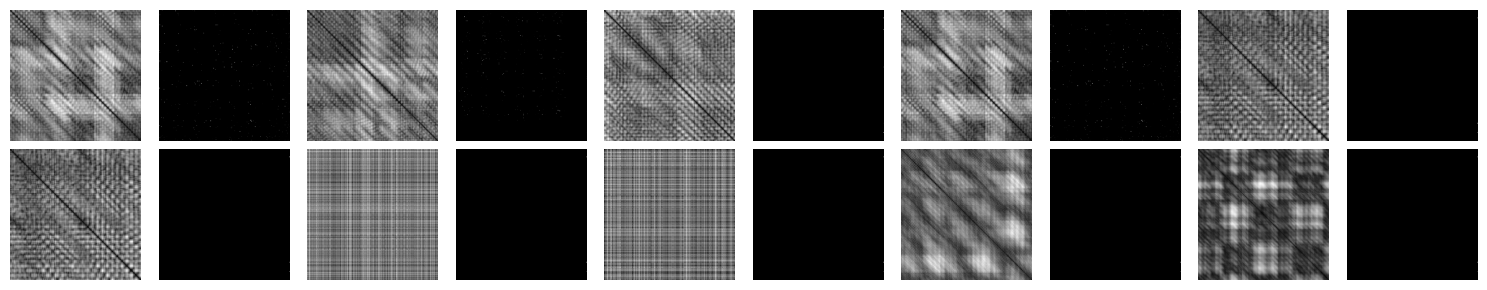

In [7]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        outputs = autoencoder_model(inputs)
        show(inputs.to('cpu'), outputs[0].to('cpu'))
        break

In [8]:
embedded_data = {0:[], 1:[]}
embedding_dataset = AutoEncoderDataset(root_dir=DATASET_PATH)
embedding_dl = DataLoader(embedding_dataset, batch_size=BATCH_SIZE)

autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in embedding_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, class_ in enumerate(labels):
            embedded_data[class_.item()].append(embedding[k].cpu().numpy().reshape(1,-1)[0])

In [9]:
embedded_data[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23841684, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.45317212], dtype=float32)

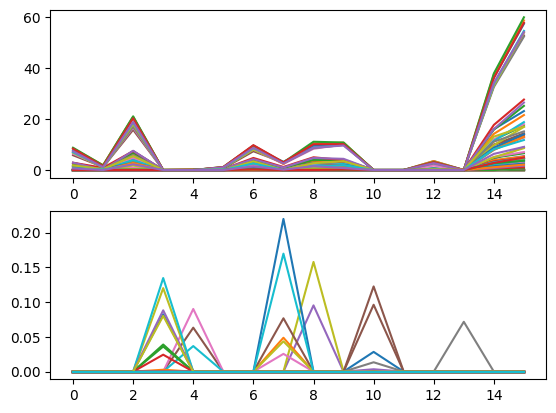

In [10]:
fig, axs = plt.subplots(2, 1)

for i in embedded_data[0]:
    axs[0].plot(i)

for i in embedded_data[1]:
    axs[1].plot(i)

plt.show()

In [11]:
class_0_data = np.array(embedded_data[0])
class_1_data = np.array(embedded_data[1])

X = np.vstack((class_0_data, class_1_data))
y = np.hstack((np.zeros(class_0_data.shape[0]), np.ones(class_1_data.shape[0])))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

y_pred = logistic_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy}')

Accuracy on Test Set: 0.9333333333333333


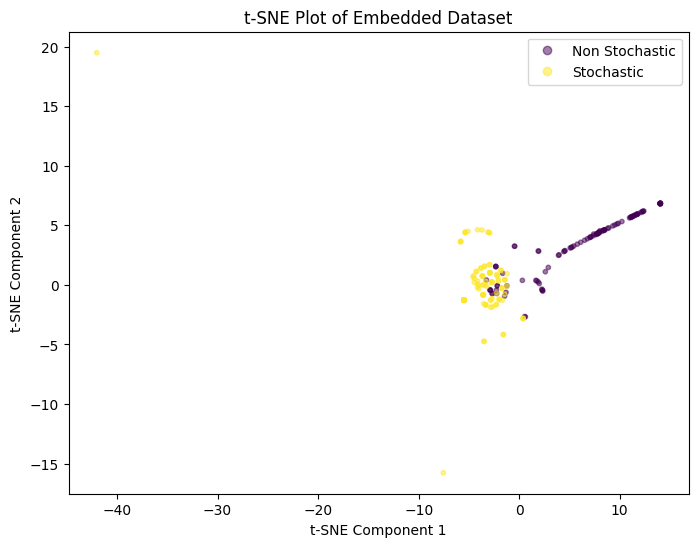

In [12]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', marker='o', s=10, alpha=0.5)

plt.title('t-SNE Plot of Embedded Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.legend(handles=scatter.legend_elements()[0], labels=['Non Stochastic', 'Stochastic'])

plt.show()

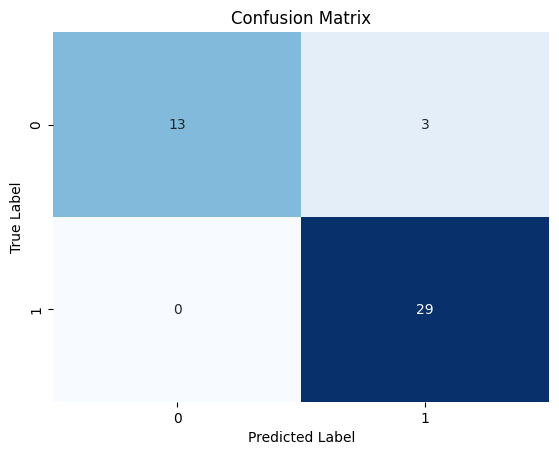

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

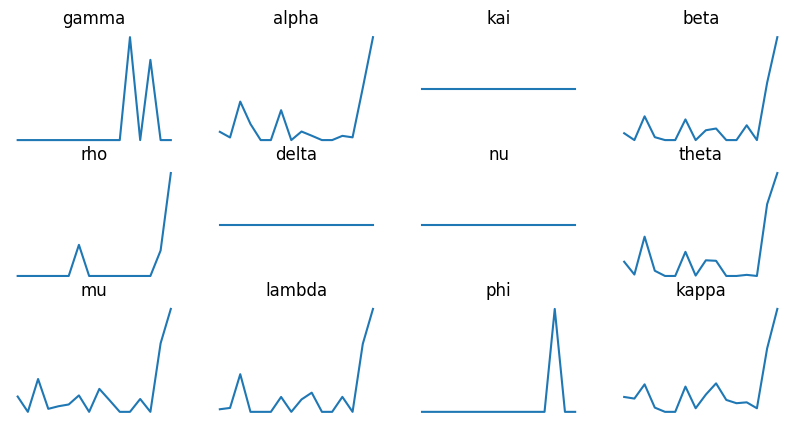

In [14]:
class TestAutoEncoderDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, f))]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = self._load_image(img_path)
        return image

    def _load_image(self, img_path):
        image = Image.open(img_path)
        transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop((225, 224)),
            transforms.Lambda(lambda img: img.crop((0, 0, img.width, img.height - 1))),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        image_tensor = transform(image)
        return image_tensor , img_path.split('/')[-1][:-9]
    
rtx_dataset = TestAutoEncoderDataset(root_dir=TEST_PATH)
rtx_dl = DataLoader(rtx_dataset, batch_size=1)

rtx_embeddings = {}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, label in rtx_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        rtx_embeddings[label[0]] = embedding.cpu().squeeze().numpy().reshape(1,-1)[0]

plt.figure(figsize=(10,5))
for i, label in enumerate(rtx_embeddings.keys()):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.title(label)
    plt.plot(rtx_embeddings[label])

plt.show()

In [15]:
rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_predictions = logistic_reg_model.predict(rtx_X)
print(rtx_predictions)

[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]


In [16]:
data = {
    'Time Series': ['kai', 'gamma', 'phi', 'delta', 'mu', 'kappa', 'nu', 'theta', 'beta', 'lambda', 'rho', 'alpha'],
    'IISER': ['Stochastic', 'Stochastic', 'Stochastic', 'Non Stochastic', 'C', 'C', 'Non Stochastic', 'Non Stochastic', 'C', 'C', 'Non Stochastic', 'Non Stochastic'],
    'CI': ['Stochastic', 'Stochastic', 'Stochastic', 'Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic'],
    'DS': ['Stochastic', 'Stochastic', 'Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic', 'Non Stochastic']
}

df = pd.DataFrame(data)
data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'LogisticReg': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

,Time Series,IISER,CI,DS,LogisticReg
0,kai,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        16
         1.0       0.97      1.00      0.98        29

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



In [18]:
rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_predictions = clf.predict(rtx_X)

data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'Decision Tree': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

,Time Series,IISER,CI,DS,LogisticReg,Decision Tree
0,kai,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic


In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgboost_classifier.fit(X_train, y_train)
y_pred = xgboost_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        16
         1.0       0.94      1.00      0.97        29

    accuracy                           0.96        45
   macro avg       0.97      0.94      0.95        45
weighted avg       0.96      0.96      0.95        45



In [20]:
rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_predictions = xgboost_classifier.predict(rtx_X)

data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'XGBoost': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

,Time Series,IISER,CI,DS,LogisticReg,Decision Tree,XGBoost
0,kai,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic


In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svm_classifier = SVC(kernel='rbf', random_state=42)  # 'rbf' stands for radial basis function, a common kernel
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46        16
         1.0       0.71      0.86      0.78        29

    accuracy                           0.69        45
   macro avg       0.66      0.62      0.62        45
weighted avg       0.67      0.69      0.67        45



In [22]:
rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_X_scaled = scaler.transform(rtx_X)
rtx_predictions = svm_classifier.predict(rtx_X_scaled)

data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'SVM': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

,Time Series,IISER,CI,DS,LogisticReg,Decision Tree,XGBoost,SVM
0,kai,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)
y_pred = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        16
         1.0       0.94      1.00      0.97        29

    accuracy                           0.96        45
   macro avg       0.97      0.94      0.95        45
weighted avg       0.96      0.96      0.95        45



In [24]:
rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_X_scaled = scaler.transform(rtx_X)
rtx_predictions = knn_classifier.predict(rtx_X_scaled)

data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'knn5': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

,Time Series,IISER,CI,DS,LogisticReg,Decision Tree,XGBoost,SVM,knn5
0,kai,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic,Non Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic,Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic


In [25]:
knn_classifier3 = KNeighborsClassifier(n_neighbors=3)
knn_classifier3.fit(X_train_scaled, y_train)
y_pred = knn_classifier3.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

rtx_names = np.array(list(rtx_embeddings.keys()))
rtx_X = np.array(list(rtx_embeddings.values()))
rtx_predictions = knn_classifier3.predict(rtx_X_scaled)

data = []
for rtx_data, prediction in zip(rtx_names, rtx_predictions):
    predicted_label = 'Stochastic' if prediction == 1 else 'Non Stochastic'

    row = {
        'Time Series': rtx_data,
        'knn3': predicted_label,
    }
    data.append(row)
    
df_new_predictions = pd.DataFrame(data)
df = pd.merge(df, df_new_predictions, on='Time Series', how='left')
df

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        16
         1.0       0.96      0.93      0.95        29

    accuracy                           0.93        45
   macro avg       0.92      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



,Time Series,IISER,CI,DS,LogisticReg,Decision Tree,XGBoost,SVM,knn5,knn3
0,kai,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
1,gamma,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
2,phi,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic
3,delta,Non Stochastic,Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
4,mu,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic
5,kappa,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
6,nu,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic,Stochastic
7,theta,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic
8,beta,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Stochastic,Stochastic
9,lambda,C,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic,Non Stochastic
